# Random seed optimization

This notebook demonstrates 'optimization' of the test train split random seed. This misuse of the random seed is intended to provide Intuitive motivation for cross-validation.

## 1. Notebook set-up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

## 2. Data preparation

In [2]:
data_url='https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv'
data_df=pd.read_csv(data_url, sep=';')

data_df.drop('pdays', axis=1, inplace=True)

categorical_features=['job','marital','default','housing','loan','contact','poutcome']

encoder=OneHotEncoder(drop='first', sparse_output=False)
encoding_features=encoder.fit_transform(data_df[categorical_features])

encoded_features_df=pd.DataFrame(
    encoding_features,
    columns=encoder.get_feature_names_out()
)

numerical_features=['age','duration','campaign','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

standard_scaler=StandardScaler()
scaled_features=standard_scaler.fit_transform(data_df[numerical_features])

scaled_features_df=pd.DataFrame(
    scaled_features,
    columns=numerical_features
)

def encode_time_features(data_df: pd.DataFrame) -> pd.DataFrame:
    '''Takes a Pandas dataframe and uses cyclical sin/cos to encode
    month and day features. Returns updated dataframe.'''

    time_df=data_df.copy()

    # First convert the features to numeric
    dict={'mon' : '1', 'tue' : '2', 'wed': '3', 'thu' : '4', 'fri': '5'}
    time_df['day_of_week']=time_df['day_of_week'].replace(dict)

    dict={'jan' : '1', 'feb' : '2', 'mar': '3', 'apr' : '4', 'may': '5', 'jun': '6', 'jul': '7', 'aug': '8', 'sep': '9', 'oct': '10', 'nov': '11', 'dec': '12'}
    time_df['month']=time_df['month'].replace(dict)

    # And fix the dtypes
    time_df['day_of_week']=time_df['day_of_week'].astype(float)
    time_df['month']=time_df['month'].astype(float)

    # Now encode the day and month with sin/cos components
    time_df['day_sin']=np.sin(2 * np.pi * time_df['day_of_week']/7.0)
    time_df['day_cos']=np.cos(2 * np.pi * time_df['day_of_week']/7.0)

    time_df['month_sin']=np.sin(2 * np.pi * time_df['month']/12.0)
    time_df['month_cos']=np.cos(2 * np.pi * time_df['month']/12.0)

    # Drop the original string features
    time_df.drop(['month', 'day_of_week'], axis=1, inplace=True)

    return time_df.reset_index(drop=True)

time_features_df=encode_time_features(data_df[['day_of_week', 'month']])

# Combine the dataframes back together
encoded_data_df=pd.concat([encoded_features_df, scaled_features_df, time_features_df], axis=1)

# Last, encode the labels
label_encoder=LabelEncoder()
encoded_data_df['y']=label_encoder.fit_transform(data_df['y'])

## 3. Iterative train-test split

In [3]:
%%time

test_accuracies=[]

for i in range(100):
    
    # Do the test-train split
    training_df, testing_df=train_test_split(
        encoded_data_df,
        test_size=0.3
    )

    # Separate features and labels
    training_labels=training_df['y']
    training_features=training_df.drop('y', axis=1)

    testing_labels=testing_df['y']
    testing_features=testing_df.drop('y', axis=1)

    model=LogisticRegression()
    model.fit(training_features, training_labels)

    test_predictions=model.predict(testing_features)
    test_accuracy=accuracy_score(testing_labels, test_predictions)*100
    test_accuracies.append(test_accuracy)
    print(f'Test set accuracy: {test_accuracy:.2f}%')

Test set accuracy: 91.00%
Test set accuracy: 91.15%
Test set accuracy: 90.89%
Test set accuracy: 91.24%
Test set accuracy: 91.15%
Test set accuracy: 91.14%
Test set accuracy: 90.85%
Test set accuracy: 90.77%
Test set accuracy: 90.65%
Test set accuracy: 90.91%
Test set accuracy: 91.07%
Test set accuracy: 90.85%
Test set accuracy: 90.98%
Test set accuracy: 91.02%
Test set accuracy: 90.94%
Test set accuracy: 90.90%
Test set accuracy: 90.97%
Test set accuracy: 91.17%
Test set accuracy: 90.91%
Test set accuracy: 91.18%
Test set accuracy: 90.94%
Test set accuracy: 91.26%
Test set accuracy: 91.26%
Test set accuracy: 90.81%
Test set accuracy: 90.90%
Test set accuracy: 90.56%
Test set accuracy: 90.62%
Test set accuracy: 90.93%
Test set accuracy: 90.61%
Test set accuracy: 90.89%
Test set accuracy: 90.97%
Test set accuracy: 91.01%
Test set accuracy: 91.15%
Test set accuracy: 90.68%
Test set accuracy: 90.89%
Test set accuracy: 91.06%
Test set accuracy: 90.80%
Test set accuracy: 90.67%
Test set acc

## 4. Test set accuracy distribution

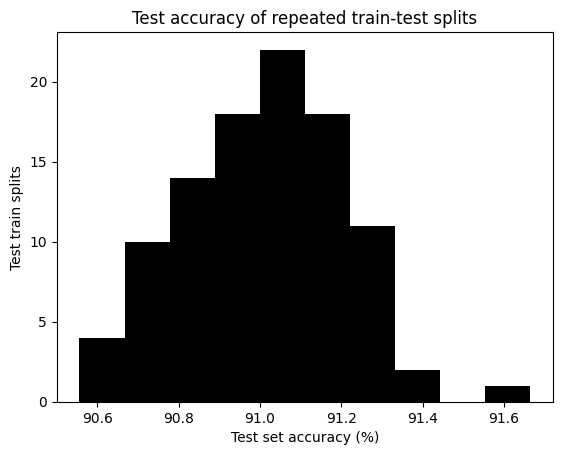

In [5]:
plt.title('Test accuracy of repeated train-test splits')
plt.hist(test_accuracies, color='black')
plt.ylabel('Test train splits')
plt.xlabel('Test set accuracy (%)')
plt.show()